## Correspondencia de Características (Match)

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

In [2]:
# Cargamos la imagen a buscar
img1 = cv.imread('robot_mask.png',cv.IMREAD_GRAYSCALE)

# Cargamos la imagen de búsqueda
img2 = cv.imread('rbt_scn2.png',cv.IMREAD_GRAYSCALE)

#### 1. Generamos las características con ORB

In [3]:
# Inicializamos el detector ORB
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

print(len(kp1))
print(len(kp2))

500
500


#### 1.1. Coincidimos con Fuerza Bruta

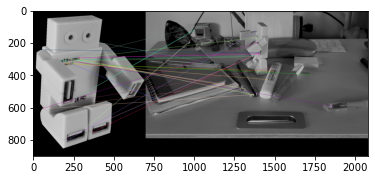

(<matplotlib.image.AxesImage at 0x201dd47ca30>, None)

In [4]:
# Cremos el objeto BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Coincidimos descriptores.
matches = bf.match(des1,des2)

# Los ordenamos según distancia
matches = sorted(matches, key = lambda x:x.distance)

# Dibujamos las primeras 30 coincidencias
n=30
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

#### 2. Generamos las características con SIFT

In [5]:
# Creamos el vector de características SIFT
sift = cv.xfeatures2d.SIFT_create()

# Y buscamos según el algoritmo...
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

print(len(kp1))
print(len(kp2))

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\opencv_contrib-4.0.1\modules\xfeatures2d\src\sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SIFT::create'


#### 2.1 Coincidimos con Fuerza Bruta y verificación de proporción (1er & 2do vecino cercano)

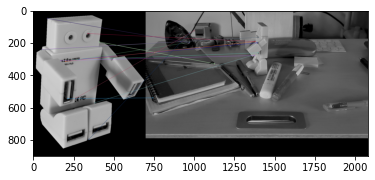

(<matplotlib.image.AxesImage at 0x201de8efbe0>, None)

In [6]:
# BFMatcher con parámetros por defecto
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Aplicar test de proporción
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])

# cv.drawMatchesKnn espera una lista de listas como coincidencias
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_DEFAULT)
plt.figure()
plt.imshow(img3),plt.show()

#### 2.2 Coincidimos con FLANN (Fast Library for Approximate Nearest Neighbors)

Colección de algoritmos optimizados para búsqueda rápida de vecinos cercanos.

In [7]:
# parámetros FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # o pasar un diccionario vacío
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Necesidad de dibujar solo las coincidencias buenas, se crea una máscara
matchesMask = [[0,0] for i in range(len(matches))]

# Ratio de verificación como figura en el paper de Lowe
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\flann\src\miniflann.cpp:315: error: (-210:Unsupported format or combination of formats) in function 'cv::flann::buildIndex_'
> type=0
> 

#### 2.3 Coincidimos con FLANN + Homografía

In [8]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Guardar todos las buenas coincidencias según la verificación de Ratio de Lowe
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(len(good))

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\flann\src\miniflann.cpp:315: error: (-210:Unsupported format or combination of formats) in function 'cv::flann::buildIndex_'
> type=0
> 

In [9]:
MIN_MATCH_COUNT = 10

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "No se encontraron suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

AttributeError: 'list' object has no attribute 'queryIdx'

In [10]:
draw_params = dict(matchColor = (0,255,0), # dibujar coincidencias en verde
                   singlePointColor = None,
                   matchesMask = matchesMask, # dibujar solo inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

NameError: name 'matchesMask' is not defined